# etf_technical_2020.05.20 (open-lagging close-leading).ipynb
---


## Notes:
* Modified [etf_technical_2020.05.17  (features + profiling)](http://localhost:18888/notebooks/research/etf_technical/etf_technical_2020.05.17%20(features%2Bprofiling).ipynb) to 
    + Use open prices to compute lagging returns (the last version used close prices)
    + Use close prices to compute leading returns (the last version used close prices)

## Version Info

### Accompanied by:
* `etf_data_apr2020.py`
* `etf_technical_20200517.py`

### Git Hashes
* madmax   `07f7d8e..ca870eb`
* research `4efc046`


---
## History

#### [etf_technical_2020.05.17  (features + profiling)](http://localhost:18888/notebooks/research/etf_technical/etf_technical_2020.05.17%20(features%2Bprofiling).ipynb)
* adding ta-lib like features for 500 ETFs
* Profiled the features
* Online learning model (pretty decent results)

##### `etf_technical_2020.05.13`
* I had gotten omega weighting done (seems to add a little bit but not much)


In [1]:
# preamble
%alias_magic  nbagg matplotlib -p nbagg
%alias_magic  inline matplotlib -p inline
%load_ext memory_profiler

from pylab import *
from madmax.api import *
mx = mx.reload()
mxtr = mxtr.reload()


###################################################################
# Interactive configuration 
# When running a config grid this will throw a FrozenException 
# and the grid Config will be used
###################################################################
try:
    mx.Config.name = 'etf_technical/technical/2020.05.17'
    mx.Config.mode = 'interactive'
    mx.Config.hps = mx.HPSet()
    mx.Config.code = 'etf_technical_2020.05.17 (talib).ipynb'
    disp( 'Running template configuration ', h=2 )        
except mx.Config.FrozenException:
    if mx.Config.mode != 'grid':
        raise RuntimeError( 'An unexpected configruation encountered' )
    disp( 'Running a grid configuration ', h=2 )

device = 'cuda'
dtype = tr.float32
hps = mx.HPSet(
    start = '20070101',    
    INTS_PER_DAY = 13,
)

mx.Config.start()


# to run run a grid of hyperparameters ...
####################################

# # hyperparameters
# mx.Config.hps = fr.HPSet( 
  
# )
# mx.Config.code = ''

# # configs = []
# # for obs_weight in ['no_weight', 'dollar_weight', 'log_weight']:
# #     cfg = fr.Config.clone()
# #     cf
# #     cfg.hps = cfg.hps.clone( obs_weight=obs_weight )
# #     cfg.freeze()
# #     display_html( cfg )
# #     configs.append( cfg )
# # notebook = fr.Config.run_grid( configs, outfile=fr.Config.uri+'/../cadre_price_index.20200302 - weight_grid_results.ipynb', n_jobs=None )



Created `%nbagg` as an alias for `%matplotlib nbagg`.
Created `%inline` as an alias for `%matplotlib inline`.


<IPython.core.display.Javascript object>

<h1> Config etf_technical/technical/2020.05.17 </h1>
<b> hash</b>: none </h4>
<b> mode </b>: interactive
<b> frozen </b>: False
<b> uri </b>: /home/fj/experiments/etf_technical/technical/2020.05.17/none
<h3> Hyperparameters </h3>
HPSet(
	)<h3> Code </h3>
<b> format </b>: .ipynb
<b> code </b> : /local/cloud/code/research/etf_technical/etf_technical_2020.05.17 (talib).ipynb

<IPython.core.display.Javascript object>


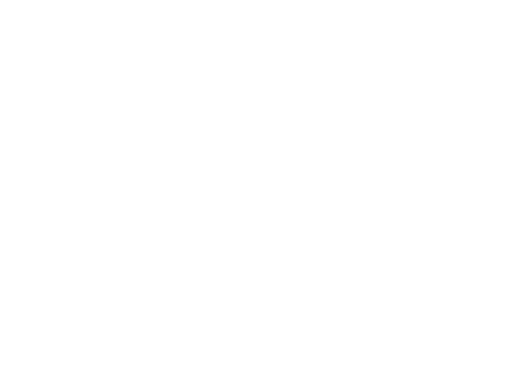

/home/fj/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


In [2]:
# identify the universe of ETFS
#############################################################
%nbagg
from research.etf_technical import etf_data_apr2020 as etfd; reload( etfd )

hps.universe = mx.HPSet(
    start = '20100101',
    end='20200401',
    min_count=2000,
    min_dollar_vol=1e5
)
etf_stats = etfd.compute_etf_stats()
etf_stats = etf_stats[etf_stats.vendor=='kibot']
orig_len = len( etf_stats )
# drop etfs without enough history
etf_stats = etf_stats[(etf_stats['start'] <= hps.universe.start ) 
                      & (etf_stats['end'] > hps.universe.end ) 
                      & (etf_stats['n'] >= hps.universe.min_count)
                      & (etf_stats['daily_dollar_volume_adj'] >= hps.universe.min_dollar_vol ) ]

disp( 'after filtering', len( etf_stats ), 'symbols out of original ' ,orig_len )

etf_stats = (etf_stats
             .merge( etfd.all_etfs, how='left', left_on='symbol', right_on='Symbol' )
             .drop( columns=['Symbol', 'ETP Name', 'Leveraged / Inverse' ])
             .rename( columns={'Asset Class':'asset_class', 'Description':'name'} )
             .fillna( 'Not Specified')             
             .set_index('symbol')
            )
disp( etf_stats.groupby('asset_class').name.count() )

ax = subplot( 2,2, 1 )
etf_stats.n.hist(ax=ax, bins=50)
ax.set_title( 'counts')

ax = subplot( 2,2, 2 )
etf_stats.start.hist(ax=ax, bins=50)
ax.set_title( 'start dates')

ax = subplot( 2,2, 3 )
etf_stats.daily_dollar_volume_adj.log10().hist(ax=ax, bins=50)
ax.set_title( 'log10 daily dollar volume')

# this is the universe we will work with. 
# HERO has a massive returns spike in 2015.11.09 - which throws off residualization quite a bit.
hps.universe.symbols = sorted( etf_stats.index.values )


In [3]:
# build up the data and features
#############################################
%inline
from research.etf_technical import etf_data_apr2020 as etfd; reload( etfd )
from research.etf_technical import etf_technical_20200517 as etfrc; reload( etfrc )

# fetch the data as a dataarray
builder = etfd.BuildDataWithAfacs( symbols=hps.universe.symbols, mkt_only=True, start=hps.start ,).set( memoize=True )
builder.data = None
disp( 'builder BuildDataWithAfacs_7f79ef4bf  expected got', builder.hash() )
da = builder(  )
df = builder.output_meta

# hyperparams related to computing returns and residuals
hps.returns_hps = mx.HPSet(    
    price_windows=[ 24*1, 24*5, 24*10],
    beta_halflifes=[13 * 90, 13 * 180, 13 * 252, 13*500],
    dollar_volume_window=13*180,
    ema_halflifes=[20 * 13, 60 * 13, 252 * 13],
    resid_halflife=13,
    
)
# compute log-returns, log-dollar-volume, betas, residual returns and clean up the data
rtn_computer = etfrc.compute_returns_and_betas( 
    start=hps.start, end=None,     
    dollar_volume_window=hps.returns_hps.dollar_volume_window, 
    price_windows = hps.returns_hps.price_windows,
    beta_halflifes=hps.returns_hps.beta_halflifes, 
    resid_halflife=None,    
) 
rtn_computer.data = builder
disp( 'expected compute_returns_and_betas_a7e712d9f  got', rtn_computer.hash(), h=4, color='teal' )

# add relative price and relative volume features
rel_price_and_vols = etfrc.add_relative_price_and_volumes( emas=hps.returns_hps.ema_halflifes )
rel_price_and_vols.data = rtn_computer
disp( 'expected add_relative_price_and_volumes_957828a97   got', rel_price_and_vols.hash(), h=4, color='teal' )

# add volatility and calendar features
add_vols = etfrc.add_volatilities( emas=hps.returns_hps.ema_halflifes )
add_vols.data = rel_price_and_vols
disp( 'expected add_volatilities_8a70bcc77 got', add_vols.hash(), h=4, color='teal' )


da = add_vols(  )




/home/fj/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/fj/cloud/code/madmax/operators/time_series.py:256: RuntimeWarning: invalid value encountered in sqrt
  cdf_std = lambda: np.sqrt( c2df_mean() - cdf_mean() ** 2 )


In [4]:
# the features built up to now
############################################

hps.feature_set = mx.HPSet(
    unadj_prices=[
        'open_unadj_30min', 'high_unadj_30min', 'low_unadj_30min', 'close_unadj_30min', 'mid_unadj_30min',
        'log_open_unadj_30min', 'log_close_unadj_30min',
    ],
    adj_prices=[
        'open_adj_30min', 'high_adj_30min', 'low_adj_30min', 'close_adj_30min',
        'mid_adj_30min', 'mid_adj_0D.12h.vwap', 'mid_adj_2D.12h.vwap', 'mid_adj_5D.vwap',
        'open_adj_0D.12h', 'high_adj_0D.12h', 'low_adj_0D.12h',
        'open_adj_2D.12h', 'high_adj_2D.12h', 'low_adj_2D.12h',
        'open_adj_5D', 'high_adj_5D', 'low_adj_5D',
    ],
    rel_prices=[
        'rel_price_260', 'rel_price_780', 'rel_price_3276',
    ],
    volumes=[
        'volume_unadj_30min', 'dollar_volume_unadj_30min', 'avg_dollar_volume',
    ],
    log_volumes=[
        'log10_dollar_volume_30min', 'log10_dollar_volume_30min_resid',
    ],
    rel_volume=[
        'rel_dollar_volume_260', 'rel_dollar_volume_780',
        'rel_dollar_volume_3276',
    ],
    calendar=[
        'timeofday', 'cos1_timeofday', 'cos2_timeofday', 'cos4_timeofday',
        'dayofweek', 'cos1_dayofweek', 'cos2_dayofweek',
        'weekofmonth', 'cos1_weekofmonth', 'cos2_weekofmonth',
        'monthofquarter', 'cos1_monthofquarter', 'cos2_monthofquarter',
        'quarterofyear', 'cos1_quarterofyear', 'cos2_quarterofyear',
    ],
    lagging=[
        'lagrtn_adj_30min', 'lagrtn_adj_1hr', 'lagrtn_adj_1day',
        'lagrtn_adj_30min_resid',
    ],
    mkt=[
        'mkt_lagrtn_30min',
        'mkt_lagrtn_30min_260.rw_sd', 'mkt_lagrtn_30min_780.rw_sd', 'mkt_lagrtn_30min_3276.rw_sd',
    ],
    vol=[
        'lagrtn_adj_30min_260.rw_sd', 'lagrtn_adj_30min_780.rw_sd', 'lagrtn_adj_30min_3276.rw_sd',
        'lagrtn_adj_30min_resid_260.rw_sd', 'lagrtn_adj_30min_resid_780.rw_sd', 'lagrtn_adj_30min_resid_3276.rw_sd',
    ],
    zscores=[
        'lagrtn_adj_30min_260.rw_zscore', 'lagrtn_adj_30min_780.rw_zscore', 'lagrtn_adj_30min_3276.rw_zscore',
        'lagrtn_adj_30min_resid_260.rw_zscore', 'lagrtn_adj_30min_resid_780.rw_zscore',
        'lagrtn_adj_30min_resid_3276.rw_zscore',
    ],
    betas=[
        'lagrtn_adj_30min_1170.ew_beta', 'lagrtn_adj_30min_2340.ew_beta',
        'lagrtn_adj_30min_3276.ew_beta', 'lagrtn_adj_30min_6500.ew_beta',
    ],
    afacs=[ 'bw_afac_30min', 'fw_afac_30min' ],
    technical=[
        'true_range_30min', 'true_range_0D.12h', 'true_range_2D.12h', 'true_range_5D',
        'direction_30min', 'direction_0D.12h', 'direction_2D.12h', 'direction_5D',
        'delta_rtn_30min', 'delta_rtn_0D.12h', 'delta_rtn_2D.12h', 'delta_rtn_5D',
        'ttp_high_adj_0D.12h', 'ttp_high_adj_2D.12h', 'ttp_high_adj_5D',
        'ttp_low_adj_0D.12h', 'ttp_low_adj_2D.12h', 'ttp_low_adj_5D',    
    ]
)
hps.leading_rtns = [
    'leadrtn_adj_30min', 'leadrtn_adj_1hr', 'leadrtn_adj_1day',
    'mkt_leadrtn_30min', 'mkt_leadrtn_1day',
]
hps.weights = ['valid_30min', 'weight', ]
       
       
       

In [ ]:
##### Profile the various sub-feature sets computed (don't run this too often - the profiler has fucked up checkpoints)
###########################################################################################
%inline
@mx.operatorize( memoize=True, produces_features=False )
def FeatureCorrelations( data, features, start, frac=0.5 ):
    '''computer feature set correlations'''
    data = data.loc[start:, :, features]
    if frac:
        ix = pd.Series( range( len( data ) ) ).sample( frac=frac, random_state=1 )
        data = data[ix.values]
    return data.corr()

def process_one_feature_set( data=add_vols, fs_features=None, leading=hps.leading_rtns ):
    '''profile one feature set '''
    with mx.timer( 'computing feautre coorelations' ):
        fc = FeatureCorrelations( start='20150101' )
        fc.data = data
        fc.features = fs_features + leading
        corr_df = fc()
    with mx.timer( 'running profile' ):
        #  -- profile the features
        profiler = mx.FeatureProfiler(
            returns=['leadrtn_adj_30min', 'leadrtn_adj_1day',],
            exposures=['valid_30min', 'lagrtn_adj_30min_1170.ew_beta', 'mkt_lagrtn_30min'],
            transforms=None, weight='weight', winsorize=0.05, xs=None, start='20150101',
            lags=[1, 3, 5], autocorr=[1, 2, 13]
        ).set( verbose=False, memoize=True )
        profiler.data = data
        profiler.features = fs_features
        profiler.run()
    return corr_df, profiler

for fs in hps.feature_set.keys():    
    fs_features = getattr( hps.feature_set, fs )
    disp( 'processing ', fs_features, h=2 )
    corr_df, profiler = process_one_feature_set( fs_features=fs_features ) 
    mx.disp( corr_df.loc[fs_features], corr=True )    
    profiler.display()     
    
    

In [ ]:
# online learning model 
########################
%inline
mx = mx.reload()
mxtr = mxtr.reload()
mx.online = mx.online.reload()
mx.Config.start()

disp( mx.tensorboard.start_server() )
disp( mx.tensorboard.start( clear=True ) )
  
hps.online = mx.HPSet(
    features=sorted( set(
        ['open_unadj_30min', 'log_open_unadj_30min', 'lagrtn_adj_30min_resid',  ] 
        + hps.feature_set.lagging 
        + hps.feature_set.vol 
        + hps.feature_set.mkt + hps.feature_set.betas
        + hps.feature_set.technical,
    ) ),
    symbol=None,
    target='leadrtn_adj_30min',
    target_shift=None, # advance the target
    lookahead=2,
    ridge=1e-4,
    hl_1 = 50,
    hl_2 = 1000,
    lr = 100,
    kappa=1, # util penalty
    rnn_tv=None, #{1:1, 2:1, 13:1e-1},
    ortho=2,
    ortho_hl=13,
    # orthogonalize out short term mean reversion
    ortho_features = ['valid_30min', 'lagrtn_adj_30min', 'lagrtn_adj_1day'] + hps.feature_set.betas,
    weight='valid_30min',
    algo='mbprox', #'mbprox',    
    # stuff related to sid weighting
    use_omega='Q',
    omega_lr = 1000,
    omega_ridge = 0,
    omega_shift = None,
    pre_winsorize=0.01,
    batch_demean=False,
    batch_normalize=False,
    transformer=dict( pre_normalize=True, quadratic=True, post_normalize=True, ema_halflifes=None,  ),
    start='20120101',
    end='20210101',    
)

@mx.operatorize( memoize=False, consumes_features=False, produces_features=True, produces_meta=True )
def OnlineRunner( da, hps, tensorboard=True, verbose=True ):
    ''' run one configuration end to end''' 
    logger = mx.Logger( 'OnlineRunner' )
    da_use = da.loc[hps.start:hps.end]
    # make sure you don't squeeze out this dimension !
    if hps.symbol:
        da_use = da_use.sel( symbol=mx.make_iterable(hps.symbol ) )            
    features = list( hps.features )
    output_features = []

    if hps.pre_winsorize:
        with logger.timer( '# pre-winsorize teh input features'):
            wins = mx.transforms.batch( sid='symbol' ).winsorize( quantiles=0.05 )
            da_use = wins( da_use, features=features )
            features = wins.output_features
        
    X = da_use.loc[:, :, features ]
    Y = da_use.loc[:, :, [hps.target]]
    # advance the target  and add thsi to the lookahead
    if hps.target_shift:
        Y = Y.lag( -hps.target_shift )
        hps.lookahead += hps.target_shift
    W = da_use.loc[:, :, [hps.weight]]
    Z = da_use.loc[:,:, hps.ortho_features ]
    
    # demean X
    if hps.batch_demean:
        X = ( X - X.mean( dim=['time','symbol']) )
    if hps.batch_normalize:
        X = X / ( X.sq().mean( dim=['time','symbol']).sqrt() + 1e-13 )        
       
    tr.cuda.empty_cache()    
    Xt = X.fillna(0).to_tensor( dtype=dtype, device=device )
    Yt = Y.fillna(0).to_tensor( dtype=dtype, device=device )
    Wt = W.fillna(0).to_tensor( dtype=dtype, device=device )
    Zt = Z.fillna(0).to_tensor( dtype=dtype, device=device )
    
    with logger.timer(" the linear rnn learner"):
        # this round about shit is because cloudpickl in the memoization fucks up nan checks
        if hps.transformer:
            tfs = []
            if hps.transformer['pre_normalize']:
                tfs.append( mx.online.OnlineNorm( demean=True, normalize=True ) )
            if hps.transformer['quadratic']:
                tfs.append( mx.online.OnlineFeatures( transform='quadratic')  )
            if hps.transformer['ema_halflifes']:
                tfs.append( mx.online.OnlineEma( halflifes=hps.transformer['ema_halflifes'] ) )
            if hps.transformer['post_normalize']:
                tfs.append( mx.online.OnlineNorm( demean=True, normalize=True ) )
            transformer = tr.nn.Sequential( *tfs )
        else:
            transformer = None
        linear_rnn = mx.online.OnlineRNN(
            lookahead=hps.lookahead, 
            ridge=hps.ridge, 
            kappa=hps.kappa, 
            algo=hps.algo,
            halflife_1=hps.hl_1,
            halflife_2=hps.hl_2,
            lr=hps.lr,
            tv=hps.rnn_tv,
            ortho=hps.ortho,
            use_omega=hps.use_omega,
            omega_lr=hps.omega_lr,
            omega_ridge=hps.omega_ridge,
            omege_shift=hps.omega_shift,
            halflife_ortho=hps.ortho_hl,
            transformer=transformer,
            verbose=verbose, 
            patience=500 if tensorboard else None,
        )            
        Yht, meta, state = linear_rnn( X=Xt, Y=Yt, W=Wt, Z=Zt, )    
        del linear_rnn;    tr.cuda.empty_cache()        
        # convert resutls to dataarray
        output_feature = f'{hps.target}_hat'
        da_use = da_use.assign_features( **{output_feature: Yht.squeeze(-1).to_dataarray( Y.squeeze(axis=-1) )  } )
        output_features.append( output_feature )

    # drop some initial data for online priming
    da_use = da_use[500:]
    del Xt, Yt, Wt, Zt, Yht;    tr.cuda.empty_cache(); gc.collect()
    
    with logger.timer('  winsorizations'):
        wins = mx.transforms.batch( sid='symbol' ).winsorize( quantiles=0.05 )
        da_use = wins( da_use, features=output_features )    
        output_features += wins.output_features

    with logger.timer( 'profiling ' ): 
        profiler = mx.FeatureProfiler(
            returns=['leadrtn_adj_30min', 'leadrtn_adj_1hr' ],
            exposures=['valid_30min', 'lagrtn_adj_30min_1170.ew_beta', 'lagrtn_adj_30min'],
            transforms=None, weight=hps.weight, winsorize=None, xs=None, 
            lags=[1, 2], autocorr=[1, 2, 13], remove_intercept=False,
        ).set(verbose=False, memoize=False)
        profiler.data = da_use
        profiler.features = output_features
        profiler.run()
    
    return da_use, output_features,  profiler.output_meta

#--- run a basic configuration ---
if True:
    hpso = hps.online
    runner = OnlineRunner( hps=hpso, verbose=True )
    runner.data = add_vols
    disp( f'Running runner={runner.hash()} with hps={hpso.hash()}', h=2 )
    dfo = runner( )
    disp( hpso )
    for profile in runner.output_meta                    :
        main_fig = profile.pop( 'main_fig' )
        exp_fig = profile.pop( 'exp_fig' )
        reg_fig = profile.pop( 'reg_fig' )
        reg_df = profile.pop( 'regressions' )
        if not reg_df.empty:
            reg_df = reg_df.set_index( ['returns', 'lag'] )
        disp( profile.pop( 'feature' ), profile.pop( 'transform' ), h=3, hr=True )
        # disp( pd.DataFrame( profile, index=['value'] ) )
        disp( 'Regressions', reg_df, h=4 )
        # disp( main_fig )
        disp( exp_fig )
        disp( reg_fig )

/home/fj/cloud/code/madmax/experiment/hpset.py:17: UserWarning: converting dict transformer={'pre_normalize': True, 'quadratic': True, 'post_normalize': True, 'ema_halflifes': None}  to OrderedDict - use HPSet instead 
  warnings.warn( f'converting dict {k}={v}  to OrderedDict - use HPSet instead ' )


,,n,finite_frac,tilt,pmSR,ic,r2,tstat,DK_60,ac_1,ac_2,ac_13
returns,lag,,,,,,,,,,,
leadrtn_adj_30min,NaN,10008944,0.890588,-0.061306,0.703085,0.024395,0.000595,72.513039,3.514622,0.687471,0.620800,0.293600
leadrtn_adj_1hr,NaN,10008944,0.890532,-0.061306,0.449383,0.025526,0.000652,75.791328,2.570010,0.687471,0.620800,0.293600
leadrtn_adj_30min,1.0,10008944,0.890535,-0.206267,-0.029027,0.008408,0.000071,24.701590,1.362503,0.685979,0.619892,0.294264
leadrtn_adj_1hr,1.0,10008944,0.890480,-0.206267,-0.103631,0.009869,0.000097,29.045254,1.367382,0.685979,0.619892,0.294264
leadrtn_adj_30min,2.0,10008944,0.890482,-0.213821,-0.113447,0.004759,0.000023,13.813819,0.838106,0.686126,0.619481,0.295312
leadrtn_adj_1hr,2.0,10008944,0.890427,-0.213821,-0.193130,0.001544,0.000002,4.600253,0.261586,0.686126,0.619481,0.295312


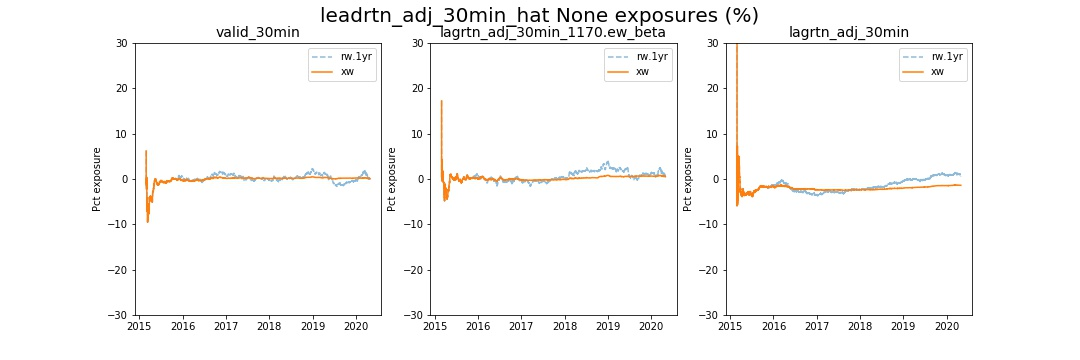

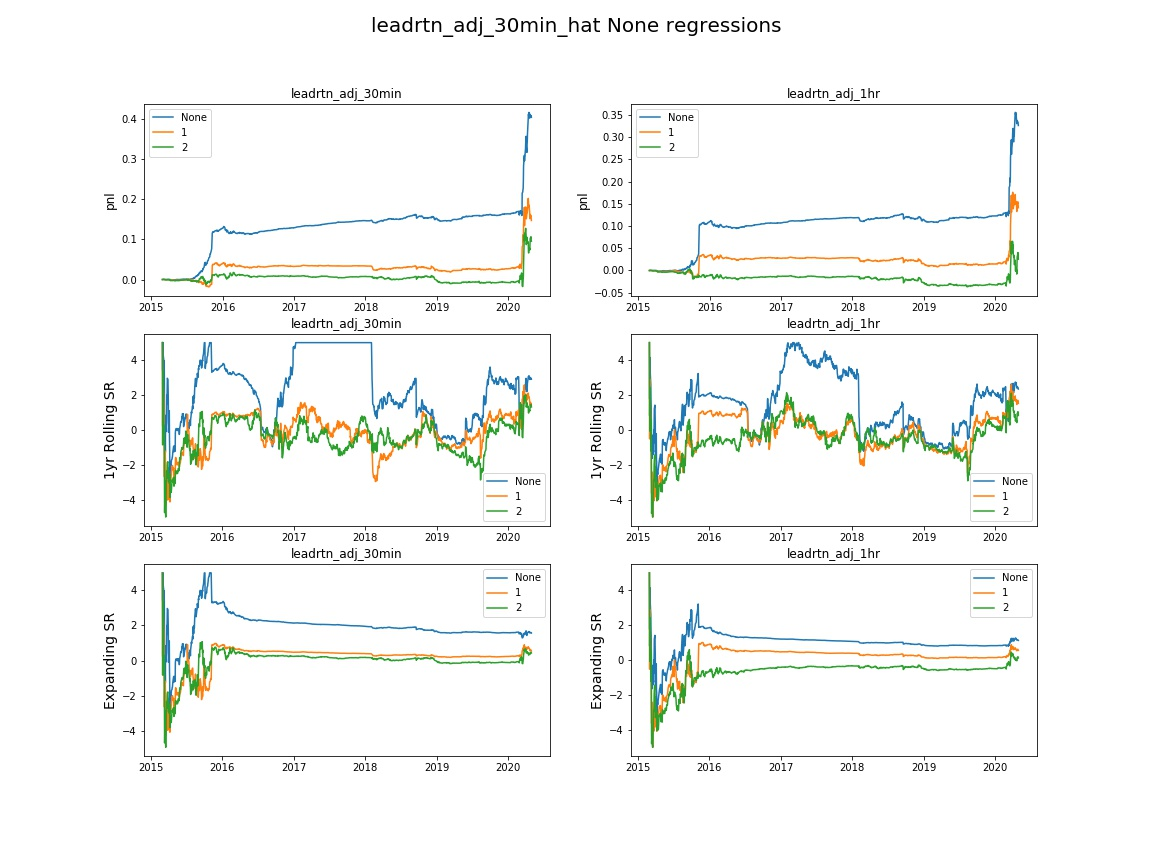

,,n,finite_frac,tilt,pmSR,ic,r2,tstat,DK_60,ac_1,ac_2,ac_13
returns,lag,,,,,,,,,,,
leadrtn_adj_30min,NaN,10008944,0.890588,-0.112445,0.724769,0.013120,0.000172,38.789536,3.699945,0.711907,0.670139,0.429390
leadrtn_adj_1hr,NaN,10008944,0.890532,-0.112445,0.429556,0.012520,0.000157,36.753647,2.379671,0.711907,0.670139,0.429390
leadrtn_adj_30min,1.0,10008944,0.890535,-0.479645,-0.115346,0.003427,0.000012,9.659661,0.864400,0.712525,0.670554,0.431493
leadrtn_adj_1hr,1.0,10008944,0.890480,-0.479645,-0.174385,0.004056,0.000016,11.598583,1.013592,0.712525,0.670554,0.431493
leadrtn_adj_30min,2.0,10008944,0.890482,-0.501086,-0.145924,0.001891,0.000004,5.131351,0.578659,0.712827,0.671013,0.431842
leadrtn_adj_1hr,2.0,10008944,0.890427,-0.501086,-0.211538,0.001092,0.000001,2.428994,0.248123,0.712827,0.671013,0.431842


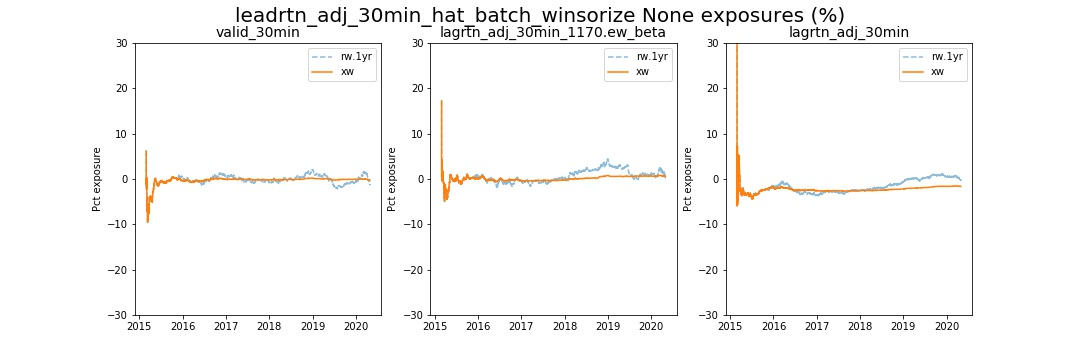

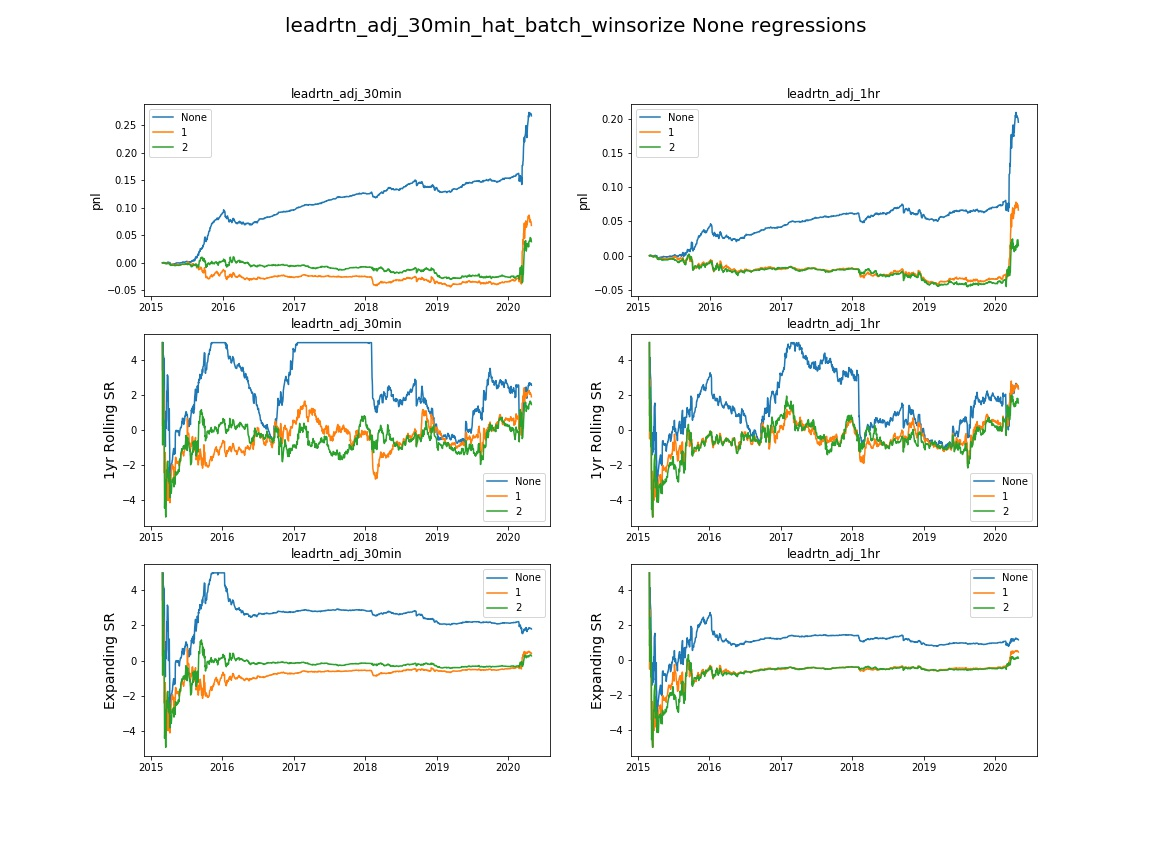

In [8]:
# online learning model 
########################
%inline
mx = mx.reload()
mxtr = mxtr.reload()
mx.online = mx.online.reload()
mx.Config.start()

disp( mx.tensorboard.start_server() )
disp( mx.tensorboard.start( clear=True ) )
  
hps.online = mx.HPSet(
    features=sorted( set(
        ['open_unadj_30min', 'log_open_unadj_30min', 'lagrtn_adj_30min_resid',  ] 
        + hps.feature_set.lagging 
        + hps.feature_set.vol 
        + hps.feature_set.mkt + hps.feature_set.betas
        +[ 'true_range_30min', 'true_range_0D.12h', 'true_range_2D.12h', 'true_range_5D',
          #  'direction_30min', 
          'direction_0D.12h', 'direction_2D.12h', 'direction_5D',
           # 'delta_rtn_30min', 
          'delta_rtn_0D.12h', 'delta_rtn_2D.12h', 'delta_rtn_5D',
            'ttp_high_adj_0D.12h', 'ttp_high_adj_2D.12h', 'ttp_high_adj_5D',
            'ttp_low_adj_0D.12h', 'ttp_low_adj_2D.12h', 'ttp_low_adj_5D',    
        ]
        #+ hps.feature_set.technical,
        #+ hps.zscores
    ) ),
    symbol=None,
    target='leadrtn_adj_30min',
    target_shift=None, # advance the target
    lookahead=2,
    ridge=1e-4,
    hl_1 = 50,
    hl_2 = 1000,
    lr = 100,
    kappa=1, # util penalty
    rnn_tv=None, #{1:1, 2:1, 13:1e-1},
    ortho=2,
    ortho_hl=13,
    # orthogonalize out short term mean reversion
    ortho_features = ['valid_30min', 'lagrtn_adj_30min', 'lagrtn_adj_1day'] + hps.feature_set.betas,
    weight='valid_30min',
    algo='mbprox', #'mbprox',    
    # stuff related to sid weighting
    use_omega='Q',
    omega_lr = 1000,
    omega_ridge = 0,
    omega_shift = None,
    pre_winsorize=0.01,
    batch_demean=False,
    batch_normalize=False,
    transformer=dict( pre_normalize=True, quadratic=True, post_normalize=True, ema_halflifes=None), #[13*5, 13*20, 13*60],  ),
    start='20150101',
    end='20210101',    
)

@mx.operatorize( memoize=False, consumes_features=False, produces_features=True, produces_meta=True )
def OnlineRunner( da, hps, tensorboard=True, verbose=True ):
    ''' run one configuration end to end''' 
    logger = mx.Logger( 'OnlineRunner' )
    da_use = da.loc[hps.start:hps.end]
    # make sure you don't squeeze out this dimension !
    if hps.symbol:
        da_use = da_use.sel( symbol=mx.make_iterable(hps.symbol ) )            
    features = list( hps.features )
    output_features = []

    if hps.pre_winsorize:
        with logger.timer( '# pre-winsorize teh input features'):
            wins = mx.transforms.batch( sid='symbol' ).winsorize( quantiles=0.05 )
            da_use = wins( da_use, features=features )
            features = wins.output_features
        
    X = da_use.loc[:, :, features ]
    Y = da_use.loc[:, :, [hps.target]]
    # advance the target  and add thsi to the lookahead
    if hps.target_shift:
        Y = Y.lag( -hps.target_shift )
        hps.lookahead += hps.target_shift
    W = da_use.loc[:, :, [hps.weight]]
    Z = da_use.loc[:,:, hps.ortho_features ]
    
    # demean X
    if hps.batch_demean:
        X = ( X - X.mean( dim=['time','symbol']) )
    if hps.batch_normalize:
        X = X / ( X.sq().mean( dim=['time','symbol']).sqrt() + 1e-13 )        
       
    tr.cuda.empty_cache()    
    Xt = X.fillna(0).to_tensor( dtype=dtype, device=device )
    Yt = Y.fillna(0).to_tensor( dtype=dtype, device=device )
    Wt = W.fillna(0).to_tensor( dtype=dtype, device=device )
    Zt = Z.fillna(0).to_tensor( dtype=dtype, device=device )
    
    with logger.timer(" the linear rnn learner"):
        # this round about shit is because cloudpickl in the memoization fucks up nan checks
        if hps.transformer:
            tfs = []
            if hps.transformer['pre_normalize']:
                tfs.append( mx.online.OnlineNorm( demean=True, normalize=True ) )
            if hps.transformer['quadratic']:
                tfs.append( mx.online.OnlineFeatures( transform='quadratic')  )
            if hps.transformer['ema_halflifes']:
                tfs.append( mx.online.OnlineEma( halflifes=hps.transformer['ema_halflifes'] ) )
            if hps.transformer['post_normalize']:
                tfs.append( mx.online.OnlineNorm( demean=True, normalize=True ) )
            transformer = tr.nn.Sequential( *tfs )
        else:
            transformer = None
        linear_rnn = mx.online.OnlineRNN(
            lookahead=hps.lookahead, 
            ridge=hps.ridge, 
            kappa=hps.kappa, 
            algo=hps.algo,
            halflife_1=hps.hl_1,
            halflife_2=hps.hl_2,
            lr=hps.lr,
            tv=hps.rnn_tv,
            ortho=hps.ortho,
            use_omega=hps.use_omega,
            omega_lr=hps.omega_lr,
            omega_ridge=hps.omega_ridge,
            omege_shift=hps.omega_shift,
            halflife_ortho=hps.ortho_hl,
            transformer=transformer,
            verbose=verbose, 
            patience=500 if tensorboard else None,
        )            
        Yht, meta, state = linear_rnn( X=Xt, Y=Yt, W=Wt, Z=Zt, )    
        del linear_rnn;    tr.cuda.empty_cache()        
        # convert resutls to dataarray
        output_feature = f'{hps.target}_hat'
        da_use = da_use.assign_features( **{output_feature: Yht.squeeze(-1).to_dataarray( Y.squeeze(axis=-1) )  } )
        output_features.append( output_feature )

    # drop some initial data for online priming
    da_use = da_use[500:]
    del Xt, Yt, Wt, Zt, Yht;    tr.cuda.empty_cache(); gc.collect()
    
    with logger.timer('  winsorizations'):
        wins = mx.transforms.batch( sid='symbol' ).winsorize( quantiles=0.05 )
        da_use = wins( da_use, features=output_features )    
        output_features += wins.output_features

    with logger.timer( 'profiling ' ): 
        profiler = mx.FeatureProfiler(
            returns=['leadrtn_adj_30min', 'leadrtn_adj_1hr' ],
            exposures=['valid_30min', 'lagrtn_adj_30min_1170.ew_beta', 'lagrtn_adj_30min'],
            transforms=None, weight=hps.weight, winsorize=None, xs=None, 
            lags=[1, 2], autocorr=[1, 2, 13], remove_intercept=False,
        ).set(verbose=False, memoize=False)
        profiler.data = da_use
        profiler.features = output_features
        profiler.run()
    
    return da_use, output_features,  profiler.output_meta

#--- run a basic configuration ---
if True:
    hpso = hps.online
    runner = OnlineRunner( hps=hpso, verbose=True )
    runner.data = add_vols
    disp( f'Running runner={runner.hash()} with hps={hpso.hash()}', h=2 )
    dfo = runner( )
    disp( hpso )
    for profile in runner.output_meta                    :
        main_fig = profile.pop( 'main_fig' )
        exp_fig = profile.pop( 'exp_fig' )
        reg_fig = profile.pop( 'reg_fig' )
        reg_df = profile.pop( 'regressions' )
        if not reg_df.empty:
            reg_df = reg_df.set_index( ['returns', 'lag'] )
        disp( profile.pop( 'feature' ), profile.pop( 'transform' ), h=3, hr=True )
        # disp( pd.DataFrame( profile, index=['value'] ) )
        disp( 'Regressions', reg_df, h=4 )
        # disp( main_fig )
        disp( exp_fig )
        disp( reg_fig )

In [28]:
gc.collect(); tr.cuda.empty_cache()

/home/fj/cloud/code/madmax/experiment/hpset.py:17: UserWarning: converting dict transformer={'pre_normalize': True, 'quadratic': True, 'post_normalize': True, 'ema_halflifes': [65, 260, 780]}  to OrderedDict - use HPSet instead 
  warnings.warn( f'converting dict {k}={v}  to OrderedDict - use HPSet instead ' )


,,n,finite_frac,tilt,pmSR,ic,r2,tstat,DK_60,ac_1,ac_2,ac_13
returns,lag,,,,,,,,,,,
leadrtn_adj_30min,NaN,10008944,0.890588,8.847665,0.565594,0.020580,0.000424,61.108074,3.170969,0.991055,0.986607,0.940425
leadrtn_adj_1hr,NaN,10008944,0.890532,8.847665,0.702819,0.027849,0.000776,82.818779,2.859271,0.991055,0.986607,0.940425
leadrtn_adj_1day,NaN,10008944,0.889935,8.847665,0.569565,0.025301,0.000640,75.495163,1.626181,0.991055,0.986607,0.940425
leadrtn_adj_30min,1.0,10008944,0.890535,7.799114,0.442549,0.017196,0.000296,50.969814,2.734791,0.991075,0.986672,0.940803
leadrtn_adj_1hr,1.0,10008944,0.890480,7.799114,0.567543,0.022836,0.000521,67.828445,2.574682,0.991075,0.986672,0.940803
leadrtn_adj_1day,1.0,10008944,0.889882,7.799114,0.314441,0.018711,0.000350,55.772415,1.262675,0.991075,0.986672,0.940803
leadrtn_adj_30min,2.0,10008944,0.890482,7.743304,0.368952,0.013809,0.000191,40.872055,2.583064,0.991105,0.986719,0.940907
leadrtn_adj_1hr,2.0,10008944,0.890427,7.743304,0.434435,0.018439,0.000340,54.669140,2.304585,0.991105,0.986719,0.940907
leadrtn_adj_1day,2.0,10008944,0.889830,7.743304,0.123515,0.012592,0.000159,37.516834,0.881470,0.991105,0.986719,0.940907


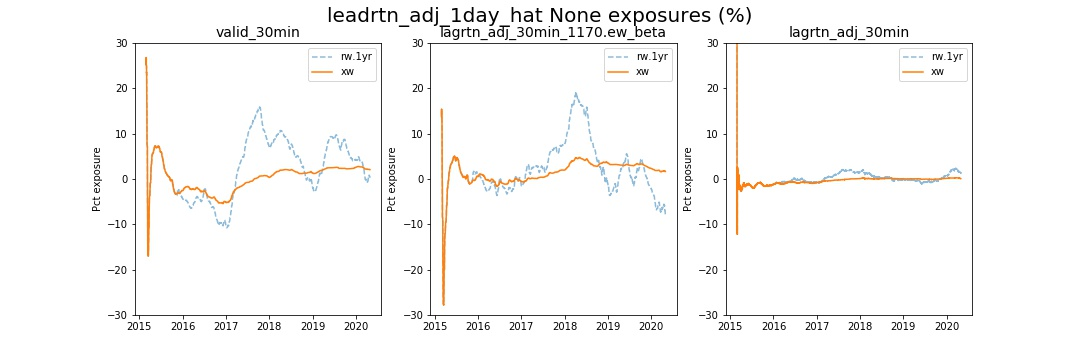

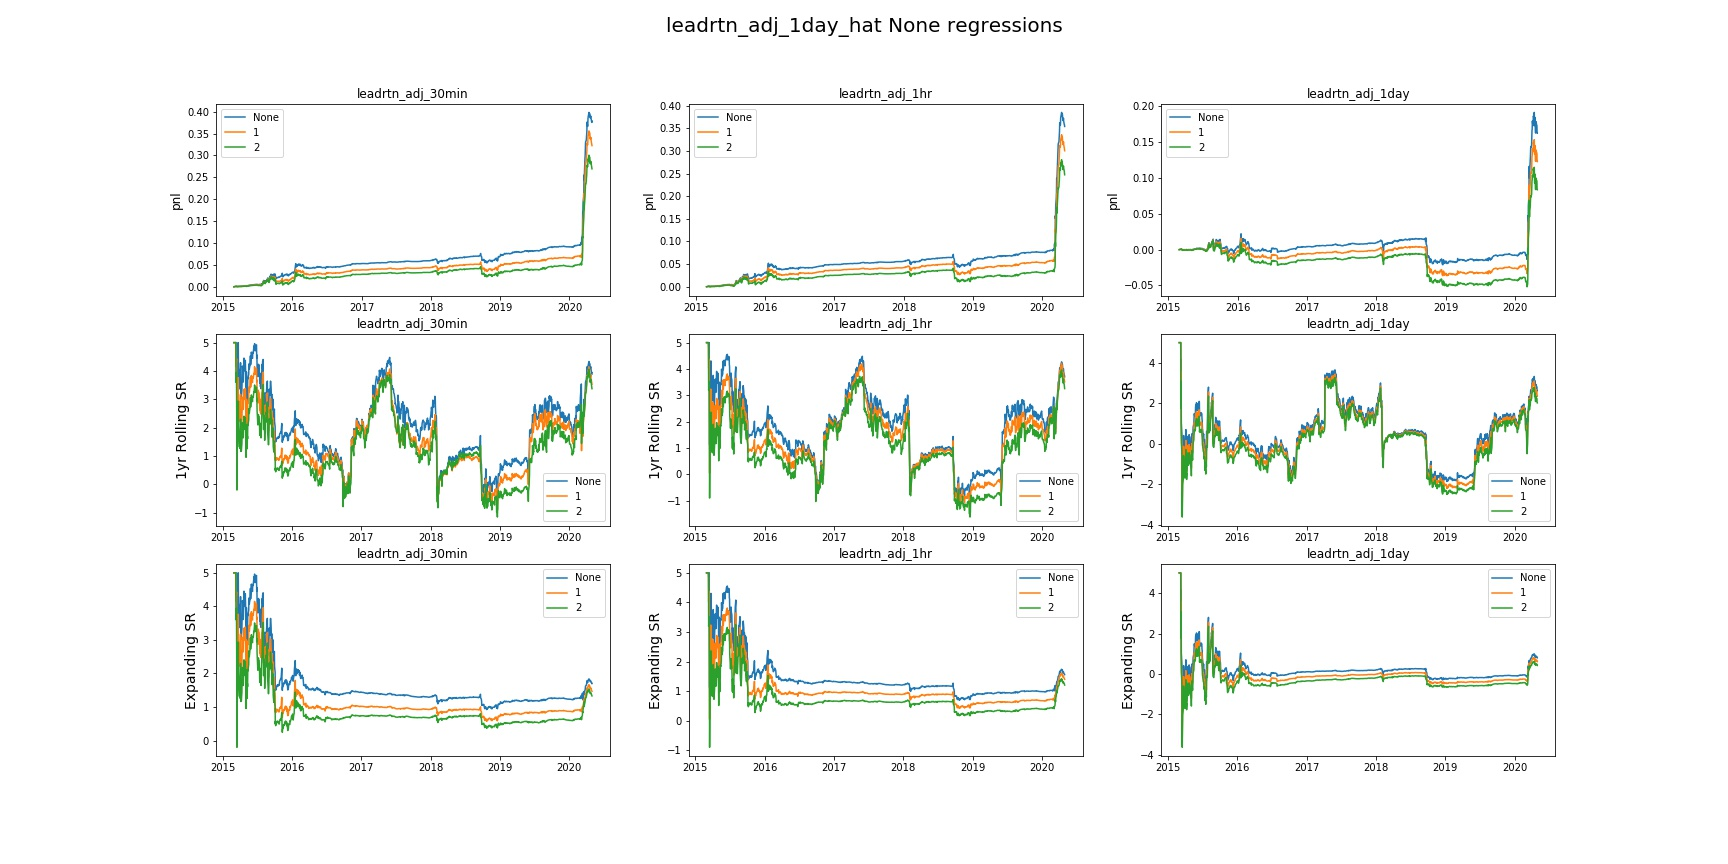

,,n,finite_frac,tilt,pmSR,ic,r2,tstat,DK_60,ac_1,ac_2,ac_13
returns,lag,,,,,,,,,,,
leadrtn_adj_30min,NaN,10008944,0.890588,22.690791,0.571295,0.012377,0.000153,36.551407,3.656261,0.992570,0.989267,0.957039
leadrtn_adj_1hr,NaN,10008944,0.890532,22.690791,0.724614,0.016522,0.000273,48.857506,3.335385,0.992570,0.989267,0.957039
leadrtn_adj_1day,NaN,10008944,0.889935,22.690791,0.710206,0.015282,0.000234,45.559174,1.760227,0.992570,0.989267,0.957039
leadrtn_adj_30min,1.0,10008944,0.890535,20.813051,0.446323,0.009851,0.000097,29.030659,3.105004,0.992611,0.989343,0.957360
leadrtn_adj_1hr,1.0,10008944,0.890480,20.813051,0.596058,0.013459,0.000181,39.613262,2.946449,0.992611,0.989343,0.957360
leadrtn_adj_1day,1.0,10008944,0.889882,20.813051,0.458251,0.011129,0.000124,33.077103,1.329065,0.992611,0.989343,0.957360
leadrtn_adj_30min,2.0,10008944,0.890482,20.707648,0.383509,0.008149,0.000066,23.972107,2.856862,0.992625,0.989376,0.957449
leadrtn_adj_1hr,2.0,10008944,0.890427,20.707648,0.474764,0.010770,0.000116,31.640516,2.576651,0.992625,0.989376,0.957449
leadrtn_adj_1day,2.0,10008944,0.889830,20.707648,0.266917,0.007453,0.000056,22.123819,0.908120,0.992625,0.989376,0.957449


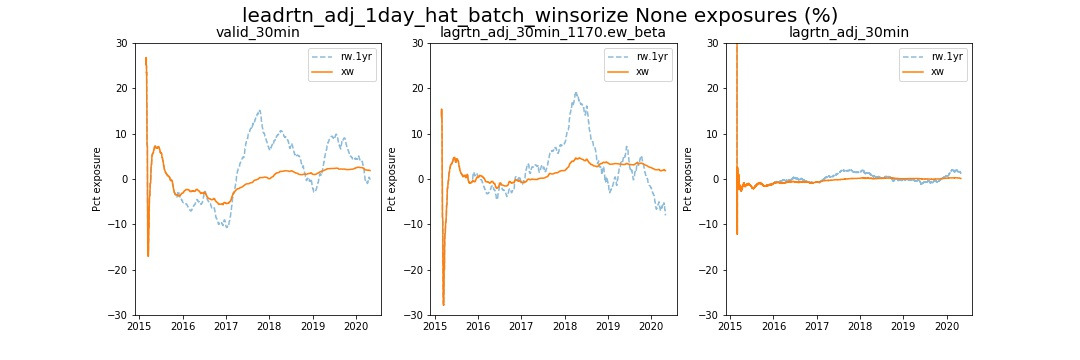

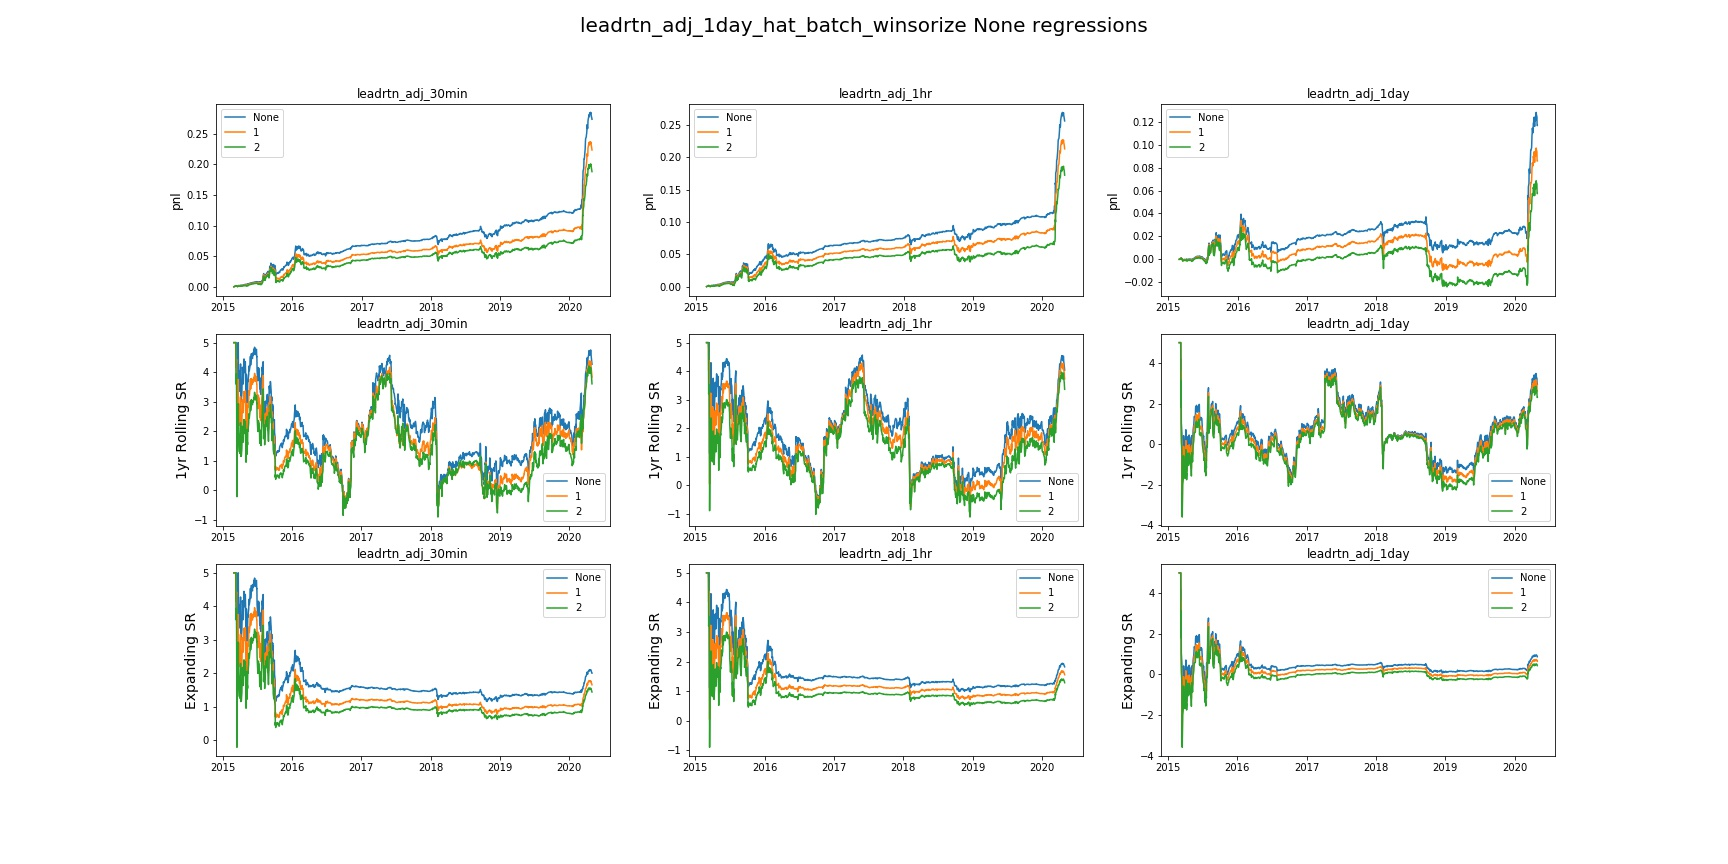

In [30]:
# online learning model using gradient descent
########################
%inline
mx.Config.start()

disp( mx.tensorboard.start_server() )
disp( mx.tensorboard.start( clear=True ) )
  
hps.online = mx.HPSet(
    features=sorted( set(
        ['open_unadj_30min', 'log_open_unadj_30min', 'lagrtn_adj_30min_resid',  ] 
        + hps.feature_set.lagging 
        + hps.feature_set.vol 
        + hps.feature_set.mkt + hps.feature_set.betas
        + hps.feature_set.technical,
    ) ),
    symbol=None,
    target='leadrtn_adj_1day',
    target_shift=0, # advance the target
    lookahead=1,
    ridge=1e-4,
    hl_1 = 13,
    hl_2 = 500,
    lr = 1e-6,
    kappa=1, # util penalty
    rnn_tv=None, #{1:1, 2:1, 13:1e-1},
    ortho=5,
    ortho_hl=13,
    # orthogonalize out short term mean reversion
    ortho_features = ['valid_30min', 'lagrtn_adj_30min', 'lagrtn_adj_1day'] + hps.feature_set.betas,
    weight='valid_30min',
    algo='gd', #'mbprox',    
    # stuff related to sid weighting
    use_omega='Q',
    omega_lr = 1000,
    omega_ridge = 0,
    omega_shift = None,
    pre_winsorize=0.01,
    batch_demean=False,
    batch_normalize=False,
    transformer=dict( pre_normalize=True, quadratic=True, post_normalize=True, ema_halflifes=[13*5, 13*20, 13*60],  ),
    start='20150101',
    end='20210101',    
)

@mx.operatorize( memoize=False, consumes_features=False, produces_features=True, produces_meta=True )
def OnlineRunner( da, hps, tensorboard=True, verbose=True ):
    ''' run one configuration end to end''' 
    logger = mx.Logger( 'OnlineRunner' )
    da_use = da.loc[hps.start:hps.end]
    # make sure you don't squeeze out this dimension !
    if hps.symbol:
        da_use = da_use.sel( symbol=mx.make_iterable(hps.symbol ) )            
    features = list( hps.features )
    output_features = []

    if hps.pre_winsorize:
        with logger.timer( '# pre-winsorize teh input features'):
            wins = mx.transforms.batch( sid='symbol' ).winsorize( quantiles=0.05 )
            da_use = wins( da_use, features=features )
            features = wins.output_features
        
    X = da_use.loc[:, :, features ]
    Y = da_use.loc[:, :, [hps.target]]
    # advance the target  and add thsi to the lookahead
    if hps.target_shift:
        Y = Y.lag( -hps.target_shift )
        hps.lookahead += hps.target_shift
    W = da_use.loc[:, :, [hps.weight]]
    Z = da_use.loc[:,:, hps.ortho_features ]
    
    # demean X
    if hps.batch_demean:
        X = ( X - X.mean( dim=['time','symbol']) )
    if hps.batch_normalize:
        X = X / ( X.sq().mean( dim=['time','symbol']).sqrt() + 1e-13 )        
       
    tr.cuda.empty_cache()    
    Xt = X.fillna(0).to_tensor( dtype=dtype, device=device )
    Yt = Y.fillna(0).to_tensor( dtype=dtype, device=device )
    Wt = W.fillna(0).to_tensor( dtype=dtype, device=device )
    Zt = Z.fillna(0).to_tensor( dtype=dtype, device=device )
    
    with logger.timer(" the linear rnn learner"):
        # this round about shit is because cloudpickl in the memoization fucks up nan checks
        if hps.transformer:
            tfs = []
            if hps.transformer['pre_normalize']:
                tfs.append( mx.online.OnlineNorm( demean=True, normalize=True ) )
            if hps.transformer['quadratic']:
                tfs.append( mx.online.OnlineFeatures( transform='quadratic')  )
            if hps.transformer['ema_halflifes']:
                tfs.append( mx.online.OnlineEma( halflifes=hps.transformer['ema_halflifes'] ) )
            if hps.transformer['post_normalize']:
                tfs.append( mx.online.OnlineNorm( demean=True, normalize=True ) )
            transformer = tr.nn.Sequential( *tfs )
        else:
            transformer = None
        linear_rnn = mx.online.OnlineRNN(
            lookahead=hps.lookahead, 
            ridge=hps.ridge, 
            kappa=hps.kappa, 
            algo=hps.algo,
            halflife_1=hps.hl_1,
            halflife_2=hps.hl_2,
            lr=hps.lr,
            tv=hps.rnn_tv,
            ortho=hps.ortho,
            use_omega=hps.use_omega,
            omega_lr=hps.omega_lr,
            omega_ridge=hps.omega_ridge,
            omege_shift=hps.omega_shift,
            halflife_ortho=hps.ortho_hl,
            transformer=transformer,
            verbose=verbose, 
            patience=500 if tensorboard else None,
        )            
        Yht, meta, state = linear_rnn( X=Xt, Y=Yt, W=Wt, Z=Zt, )    
        del linear_rnn;    tr.cuda.empty_cache()        
        # convert resutls to dataarray
        output_feature = f'{hps.target}_hat'
        da_use = da_use.assign_features( **{output_feature: Yht.squeeze(-1).to_dataarray( Y.squeeze(axis=-1) )  } )
        output_features.append( output_feature )

    # drop some initial data for online priming
    da_use = da_use[500:]
    del Xt, Yt, Wt, Zt, Yht;    tr.cuda.empty_cache(); gc.collect()
    
    with logger.timer('  winsorizations'):
        wins = mx.transforms.batch( sid='symbol' ).winsorize( quantiles=0.05 )
        da_use = wins( da_use, features=output_features )    
        output_features += wins.output_features

    with logger.timer( 'profiling ' ): 
        profiler = mx.FeatureProfiler(
            returns=['leadrtn_adj_30min', 'leadrtn_adj_1hr', 'leadrtn_adj_1day' ],
            exposures=['valid_30min', 'lagrtn_adj_30min_1170.ew_beta', 'lagrtn_adj_30min'],
            transforms=None, weight=hps.weight, winsorize=None, xs=None, 
            lags=[1, 2], autocorr=[1, 2, 13], remove_intercept=False,
        ).set(verbose=False, memoize=False)
        profiler.data = da_use
        profiler.features = output_features
        profiler.run()
    
    return da_use, output_features,  profiler.output_meta

#--- run a basic configuration ---
if True:
    hpso = hps.online
    runner = OnlineRunner( hps=hpso, verbose=True )
    runner.data = add_vols
    disp( f'Running runner={runner.hash()} with hps={hpso.hash()}', h=2 )
    dfo = runner( )
    disp( hpso )
    for profile in runner.output_meta                    :
        main_fig = profile.pop( 'main_fig' )
        exp_fig = profile.pop( 'exp_fig' )
        reg_fig = profile.pop( 'reg_fig' )
        reg_df = profile.pop( 'regressions' )
        if not reg_df.empty:
            reg_df = reg_df.set_index( ['returns', 'lag'] )
        disp( profile.pop( 'feature' ), profile.pop( 'transform' ), h=3, hr=True )
        # disp( pd.DataFrame( profile, index=['value'] ) )
        disp( 'Regressions', reg_df, h=4 )
        # disp( main_fig )
        disp( exp_fig )
        disp( reg_fig )

---- 
GARBAGE
----

# raw features to add
* open - close 

* high - low
* trailing min , trailing max price
* min / max price over a period
* time from previous high, low
* sign of above
* positive sign volatility
* negative sign volatiity
* positive/-ve volume
* diff with min, max price 



In [ ]:
ta_features = ['AD', 'ADOSC', 'ADX', 'ADXR', 'AROON_0', 'AROON_1', 'AROONOSC', 'ATR', 'AVGPRICE', 'BOP', 'CCI', 'CDL2CROWS', 'CDL3BLACKCROWS', 'CDL3INSIDE', 'CDL3LINESTRIKE', 'CDL3OUTSIDE', 'CDL3STARSINSOUTH', 'CDL3WHITESOLDIERS', 'CDLABANDONEDBABY', 'CDLADVANCEBLOCK', 'CDLBELTHOLD', 'CDLBREAKAWAY', 'CDLCLOSINGMARUBOZU', 'CDLCONCEALBABYSWALL', 'CDLCOUNTERATTACK', 'CDLDARKCLOUDCOVER', 'CDLDOJI', 'CDLDOJISTAR', 'CDLDRAGONFLYDOJI', 'CDLENGULFING', 'CDLEVENINGDOJISTAR', 'CDLEVENINGSTAR', 'CDLGAPSIDESIDEWHITE', 'CDLGRAVESTONEDOJI', 'CDLHAMMER', 'CDLHANGINGMAN', 'CDLHARAMI', 'CDLHARAMICROSS', 'CDLHIGHWAVE', 'CDLHIKKAKE', 'CDLHIKKAKEMOD', 'CDLHOMINGPIGEON', 'CDLIDENTICAL3CROWS', 'CDLINNECK', 'CDLINVERTEDHAMMER', 'CDLKICKING', 'CDLKICKINGBYLENGTH', 'CDLLADDERBOTTOM', 'CDLLONGLEGGEDDOJI', 'CDLLONGLINE', 'CDLMARUBOZU', 'CDLMATCHINGLOW', 'CDLMATHOLD', 'CDLMORNINGDOJISTAR', 'CDLMORNINGSTAR', 'CDLONNECK', 'CDLPIERCING', 'CDLRICKSHAWMAN', 'CDLRISEFALL3METHODS', 'CDLSEPARATINGLINES', 'CDLSHOOTINGSTAR', 'CDLSHORTLINE', 'CDLSPINNINGTOP', 'CDLSTALLEDPATTERN', 'CDLSTICKSANDWICH', 'CDLTAKURI', 'CDLTASUKIGAP', 'CDLTHRUSTING', 'CDLTRISTAR', 'CDLUNIQUE3RIVER', 'CDLUPSIDEGAP2CROWS', 'CDLXSIDEGAP3METHODS', 'DX', 'MEDPRICE', 'MFI', 'MIDPRICE', 'MINUS_DI', 'MINUS_DM', 'NATR', 'OBV', 'PLUS_DI', 'PLUS_DM', 'SAR', 'SAREXT', 'STOCH_0', 'STOCH_1', 'STOCHF_0', 'STOCHF_1', 'TRANGE', 'TYPPRICE', 'ULTOSC', 'WCLPRICE', 'WILLR']
features =  ['open', 'high', 'low', 'close', 'volume']

In [ ]:
import talib
fncs = []
for name in pbar( dir( talib ) ):
    # look at only transformation functions
    if not name.isupper():
        continue
    fnc = getattr( talib, name )
    # talib fncs don't have inspect.signatures 
    # so get their docstring signatures instead
    sig = fnc.__doc__.split('\n')[0]
    args = []
    fd = dict(
        fnc=fnc,
        name=name,
        sig=sig,
    )
    # see if the function takes any of these as arguments
    for ft in features:
        fd[ft] = True if re.compile( f'(\s|\(){ft}(,|\[|\))').search( sig ) else False
    # do some special hacking 
    if name == 'OBV':
        fd['close'] = True
    fncs.append( fd )    
fncs = pd.DataFrame( fncs ).set_index('name')
# pare out fncs that don't operate on the features
# fncs = fncs[fncs[features].sum(axis=1).astype(bool)]


In [ ]:
# compute talib features
###########################################


@mx.operatorize( verbose=True, memoize='d', uses_self=True )
def build_ta_features( data, features, self=None ):    
    from joblib import Parallel, delayed
    import talib
    fncs = []
    for name in pbar( dir( talib ) ):
        # look at only transformation functions
        if not name.isupper():
            continue
        fnc = getattr( talib, name )
        # talib fncs don't have inspect.signatures 
        # so get their docstring signatures instead
        sig = fnc.__doc__.split('\n')[0]
        args = []

        fd = dict(
            fnc=fnc,
            name=name,
            sig=sig,
        )
        # see if the function takes any of these as arguments
        for ft in features:
            fd[ft] = True if re.compile( f'(\s|\(){ft}(,|\[|\))').search( sig ) else False
        # do some special hacking 
        if name == 'OBV':
            fd['close'] = True
        fncs.append( fd )    
    fncs = pd.DataFrame( fncs )
    # pare out fncs that don't operate on teh features
    fncs = fncs[fncs[features].sum(axis=1).astype(bool)]

    def build_ta_features( sda ):    
        tfs = []
        for i, fd in fncs.iterrows():
            fnc = fd['fnc']
            kwargs = {f: sda[:,0,:].loc[:, f].values.astype(float64) for f in features if fd[f]}
            # some special case hacking here (bug in the docstring of OBV)
            if fd['name'] == 'OBV':
                kwargs['real'] = kwargs.pop('close')    
            # the technical feature
            tf = fnc( **kwargs )
            if isinstance( tf, tuple ):
                tf_names = [fd['name'] + f'_{i}' for i in range( len( tf ) )]
                tf = np.concatenate([t.reshape( -1, 1, 1 ) for t in tf], axis=-1)    
            else:
                tf_names = [fd['name']]
                tf = tf.reshape(-1,1,1)
            # convert to dataarray
            tf = (
                xa.DataArray( tf, dims=sda.dims )
                .assign_coords( 
                    **{sda.dims[i]: sda.coords[sda.dims[i]] for i in range( 2 ) },
                   features=tf_names 
                ) 
            )
            tfs.append( tf )
        tda = xa.concat( tfs, dim='features' )
        return tda
    
    jobs = [ delayed( build_ta_features )(  sda=data.loc[:,[sym], features] ) for sym in GOOD_POLYGON_SYMBOLS ]
    with self.timer( 'running parallel jobs'):
        outs = Parallel( n_jobs=-1, verbose=1 )( jobs )        
    ta_da = xa.concat( outs, dim='symbol' )    
    for c in ta_da.dims:
        assert (ta_da.coords[c]== data.coords[c]).all()
    output_features = ta_da.features.values.tolist()
    output_data = xa.concat( [data, ta_da], dim='features' )
    return output_data, output_features 
    
    
ta_builder = build_ta_features( )
ta_builder.data = mkt_rtn_computer
ta_builder.features = ['open', 'high', 'low', 'close', 'volume']
dh( 'Expected build_ta_features_740f3dc15 got ', ta_builder.hash(), color='orange', h=3 )

# add an additional layer of memoization since the operator is unstable
ta_data_file = os.path.join( mx.Config.uri, 'talib_data_20200304.netcdf' ) 
try:
    ta_data = mx.DataSource.dataarray( ta_data_file )    
    dh( 'Expected DataSource_a203ef133 got ', ta_data.hash(), color='orange', h=3 )
    data = ta_data()    
    dh( 'loaded ta data from ', ta_data_file, color='orange', h=3 )
except FileNotFoundError:
    data = ta_builder()
    with timer( f'saving {ta_builder.hash()} to {ta_data_file}', ):
        data.to_netcdf( ta_data_file )    

ta_features = ['AD', 'ADOSC', 'ADX', 'ADXR', 'AROON_0', 'AROON_1', 'AROONOSC', 'ATR', 'AVGPRICE', 'BOP', 'CCI', 'CDL2CROWS', 'CDL3BLACKCROWS', 'CDL3INSIDE', 'CDL3LINESTRIKE', 'CDL3OUTSIDE', 'CDL3STARSINSOUTH', 'CDL3WHITESOLDIERS', 'CDLABANDONEDBABY', 'CDLADVANCEBLOCK', 'CDLBELTHOLD', 'CDLBREAKAWAY', 'CDLCLOSINGMARUBOZU', 'CDLCONCEALBABYSWALL', 'CDLCOUNTERATTACK', 'CDLDARKCLOUDCOVER', 'CDLDOJI', 'CDLDOJISTAR', 'CDLDRAGONFLYDOJI', 'CDLENGULFING', 'CDLEVENINGDOJISTAR', 'CDLEVENINGSTAR', 'CDLGAPSIDESIDEWHITE', 'CDLGRAVESTONEDOJI', 'CDLHAMMER', 'CDLHANGINGMAN', 'CDLHARAMI', 'CDLHARAMICROSS', 'CDLHIGHWAVE', 'CDLHIKKAKE', 'CDLHIKKAKEMOD', 'CDLHOMINGPIGEON', 'CDLIDENTICAL3CROWS', 'CDLINNECK', 'CDLINVERTEDHAMMER', 'CDLKICKING', 'CDLKICKINGBYLENGTH', 'CDLLADDERBOTTOM', 'CDLLONGLEGGEDDOJI', 'CDLLONGLINE', 'CDLMARUBOZU', 'CDLMATCHINGLOW', 'CDLMATHOLD', 'CDLMORNINGDOJISTAR', 'CDLMORNINGSTAR', 'CDLONNECK', 'CDLPIERCING', 'CDLRICKSHAWMAN', 'CDLRISEFALL3METHODS', 'CDLSEPARATINGLINES', 'CDLSHOOTINGSTAR', 'CDLSHORTLINE', 'CDLSPINNINGTOP', 'CDLSTALLEDPATTERN', 'CDLSTICKSANDWICH', 'CDLTAKURI', 'CDLTASUKIGAP', 'CDLTHRUSTING', 'CDLTRISTAR', 'CDLUNIQUE3RIVER', 'CDLUPSIDEGAP2CROWS', 'CDLXSIDEGAP3METHODS', 'DX', 'MEDPRICE', 'MFI', 'MIDPRICE', 'MINUS_DI', 'MINUS_DM', 'NATR', 'OBV', 'PLUS_DI', 'PLUS_DM', 'SAR', 'SAREXT', 'STOCH_0', 'STOCH_1', 'STOCHF_0', 'STOCHF_1', 'TRANGE', 'TYPPRICE', 'ULTOSC', 'WCLPRICE', 'WILLR']


    
%nbagg
figure(figsize=(10, 20) )
for i, sym in enumerate( random_sample( GOOD_POLYGON_SYMBOLS, 25 ) ):
    sda  = data.loc[:,sym,:]    
    subplot( 5, 5, i+1)
    plot( sda.loc[:,'open'].to_series(), '-k', label='open',  )
    plot( sda.loc[:,'open'].to_series(), ':b', label='close', alpha=0.8 )
    plot( sda.loc[:,'MIDPRICE'].to_series(), '--r', label='midprice', linewidth=2, alpha=0.5 )
    gca().legend()
    gca().set_title( sym )
        

In [ ]:
# Rehsape the returns
############################################
%inline
mx = mx.reload()
mxtr = mxtr.reload()
mx.Config.start()

disp( mx.tensorboard.start_server() )
disp( mx.tensorboard.start( clear=True ) )

hps.target_reshape = mx.HPSet(
    facrtn_penalty=1e3,
    facld_penalty=1e3,
    kappa=1,
    tv={1:1, 6:1e-1, 13:1e-3},    
    facld_features = ['valid', 'lagrtn_adj_30min_1170.ew_beta', 'lagrtn_adj_30min_2340.ew_beta','lagrtn_adj_30min_3276.ew_beta'],
    facrtn_feature = ['mkt_lagrtn_30min'],
    leading_return='leadrtn_adj_30min',
    weight='weight',
)


def _roll_corr( X, Y, win=5 * 13 ):
    XY = (X * Y).mean( axis=1 )
    Xs = (X.sq()).mean( axis=1 ).sqrt()
    Ys = (Y.sq()).mean( axis=1 ).sqrt()
    XYc = 100 * (XY / (Xs + 1e-13) / (Ys + 1e-13))
    # apply a smoothing filter to the correlations
    return XYc.to_series().rolling( win, min_periods=1 ).mean(), XYc.mean().item()

def regression_results( X_da, Y_da, W_da, facrtn_da, facld_da, name=[] ):
    '''run a regression measuing factor correlations and exposures'''
    reg = mx.Regression( autocorr=[1, 6, 13], dk_lags=None )
    regs = []
    num_figs = 2 + facrtn_da.shape[-1] + facld_da.shape[-1]
    num_rows = 2
    num_cols = int( ceil(num_figs / num_rows ) )
    #--- plain regressions ---
    fig = figure( figsize=(15, 15  ) )
    rm = reg.regress( x=X_da, y=Y_da, w=W_da )    
    rm['name'] = name + ['main']
    rm.pop( 'hitRate' )
    pnl = rm.pop( 'pnl' )
    pnl = pnl.cumsum() / pnl.sum()
    regs.append( rm )
    ax = subplot( num_rows, num_cols, 1 )
    ax.plot( pnl, '-k', label='target' )
    #--- regression of the error of the target variable---
    try:
        # the error of the target
        ols = sm.OLS( exog=X_da.values.reshape(-1), endog=Y_da.values.reshape(-1),  missing='drop').fit()
        Yerr_da = xa.DataArray( Y_da.values - ols.params[0]*X_da.values, dims=Y_da.dims, coords=Y_da.coords )
        rrm = reg.regress( x=Yerr_da, y=Y_da, w=W_da )    
        rrm['name'] = name + ['error']
        rrm.pop( 'hitRate' )
        rpnl = rrm.pop( 'pnl' )
        rpnl = rpnl.cumsum() / rpnl.sum()
        regs.append( rrm )    
        ax.plot( rpnl, '--r', label='error' )
    except Error as e:
        print( 'regression on error term failed ' )
    ax.set_title( "pnl" )    
    ax.legend()    
    # rolling correlation with the factor returns
    for i, fc in enumerate( facrtn_da.features.values ):        
        frc, frm = _roll_corr( X_da, facrtn_da.loc[:,:,fc] )
        ax = subplot( num_rows, num_cols, 1 + i + 1 )
        ax.plot( frc.time_index, frc.values, '-r', alpha=0.5 )
        ax.set_title( f'{fc[-10:]}={frm:0.2f}%')
        ax.set_ylim([-15,15])
    # rolling correlation with the factor 
    for j, fc in enumerate( facld_da.features.values ):        
        frc, frm = _roll_corr( X_da, facld_da.loc[:,:,fc] )
        ax = subplot( num_rows, num_cols, 1 + i + 1 + j + 1)
        ax.plot( frc.time_index, frc.values, '-r', alpha=0.5 )
        ax.set_title( f'{fc[-10:]}={frm:0.2f}%')
        ax.set_ylim( [-15,15] )
    # scatter plot of reshaped versus original
    ax = subplot( num_rows, num_cols, 1 + i + 1 + j + 1 +1 )
    ys = Y_da.values.reshape(-1)
    xs = X_da.values.reshape(-1)
    mask = rand( len( ys ) ) < 1 / 2
    ax.plot( ys[mask], xs[mask], '.', alpha=0.5 )
    ax.set_xlabel( 'raw returns' )
    ax.set_ylabel( 'target' )
    ax.set_xlim( [-1,1] )
    ax.set_ylim( [-1,1] )    
    fig.suptitle( '_'.join( name ), fontsize=15 )
    return dict( regs=pd.DataFrame(regs).set_index('name'), fig=mx.fig2format( fig ) )     

@mx.operatorize( consumes_features=False, produces_features=True, produces_meta=True, memoize=True )
def ReshapeTarget( data, start, hps ):    
    ''' do target reshaping'''        
    Y_da = data.loc[start:,:, hps.leading_return]
    W_da = data.loc[start:,:, hps.weight ]
    facrtn_da = data.loc[start:,['SPY'], hps.facrtn_feature]
    facld_da = data.loc[start:,:,hps.facld_features ]
    target_shaper = mx.TargetShaper(
        facrtn_penalty=hps.facrtn_penalty,
        facld_penalty=hps.facld_penalty,
        facld_residualize=False,
        obj='util',
        adapted=True,
        kappa=hps.kappa,
        tv=hps.tv,
        lr=1e-2,
        rel_tol=1e-7,
        max_its=1000,
        eps=1e-12,
        facrtn_winlen=None,
        facld_winlen=None,
    ).to( device, dtype )
    target_shaper.verbose = True    
    # do the reshaping ---
    X = target_shaper( 
        Y=Y_da.to_tensor( dtype=dtype, device=device ).unsqueeze(-1),
        W=W_da.to_tensor( dtype=dtype, device=device ).unsqueeze(-1),
        facrtns=facrtn_da.to_tensor( dtype=dtype, device=device ),
        faclds=facld_da.to_tensor( dtype=dtype, device=device ),
    )    
    X_da = X.squeeze(-1).to_dataarray( Y_da ) 
    reshaped_feature = f'{hps.leading_return}_reshaped'    
    data  = data.assign_features( **{reshaped_feature:X_da } )
    regres = regression_results( X_da=X_da, Y_da=Y_da, W_da=W_da, facrtn_da=facrtn_da, facld_da=facld_da, name=['reshaped'] )
    return data, reshaped_feature, regres

target_reshaper = ReshapeTarget(
    start=hps.start,
    hps=hps.target_reshape,
)
target_reshaper.data = rtn_computer
disp( 'expected ReshapeTarget_1d28e60c5 got, ', target_reshaper.hash())

da = target_reshaper()
disp( 'reshaped returns', h=2 )
disp( target_reshaper.output_meta['regs'] )
disp( target_reshaper.output_meta['fig'] )


@mx.operatorize( memoize=True, consumes_features=False, produces_features=False, produces_meta=True )
def raw_and_resid_regressions( data, hps ):
    da = data
    raw_regs = regression_results( 
        X_da=da.loc[hps.start:,:,'leadrtn_adj_30min'],
        Y_da=da.loc[hps.start:,:,'leadrtn_adj_30min'],
        W_da=da.loc[hps.start:,:,'weight'],
        facrtn_da = data.loc[hps.start:,['SPY'], hps.target_reshape.facrtn_feature],
        facld_da = data.loc[hps.start:,:,hps.target_reshape.facld_features ],
    )
    resid_regs = regression_results( 
        X_da=da.loc[hps.start:,:,'leadrtn_adj_30min_resid'],
        Y_da=da.loc[hps.start:,:,'leadrtn_adj_30min'],
        W_da=da.loc[hps.start:,:,'weight'],
        facrtn_da = data.loc[hps.start:,['SPY'], hps.target_reshape.facrtn_feature],
        facld_da = data.loc[hps.start:,:,hps.target_reshape.facld_features ],
    )
    return data, (raw_regs, resid_regs)

with mx.timer('running raw and residaul regreressions'):
    rr = raw_and_resid_regressions(  hps=hps )
    rr.data = target_reshaper
    rr()
    raw_regs, resid_regs = rr.output_meta
    disp( 'raw returns', h=3 )
    disp( raw_regs['regs'] )
    disp( raw_regs['fig'] )
    disp( 'resid returns', h=3 )
    disp( resid_regs['regs'] )
    disp( resid_regs['fig'] )


In [ ]:
# one last stage of feature cleanup - that failed earlier because of memory blowouts

@mx.operatorize( memoize=True, consumes_features=False, produces_features=False )
def FinalStageOfFeatureCreation( da, ema_halflifes=[5*13, 20*13, 180*13, 252*13] ):    
    da = da.drop_mx( ['open_adj_30min', 'close_adj_30min', 'high_adj_30min', 'low_adj_30min', 'volume_adj_30min',
                      'dollar_volume_adj_30min', 'market', 'after_market', 'pre_market'] )
    ema = mx.transforms.exponential( sid='symbol', halflifes=ema_halflifes ).mean( weight='weight' )
    da = ema( da, features=['log10_dollar_volume_30min', 'lagrtn_adj_30min', 'mkt_lagrtn_30min','log10_dollar_volume_30min_resid', 'lagrtn_adj_30min_resid', 'atr_30min',  ] )    
    da = da.assign_features(
        log_open_unadj_30min=da.loc[:,:,'open_unadj_30min'].log(),
        log_close_unadj_30min=da.loc[:,:,'close_unadj_30min'].log()
    )
    return da
    
feature_builder = FinalStageOfFeatureCreation()
feature_builder.data = target_reshaper
disp( 'expected FinalStageOfFeatureCreation_8ba339bb2  got, ', feature_builder.hash())
da = feature_builder()

In [ ]:
# --- hyperparameter grid --
hpgrid = []
for target in ['leadrtn_adj_30min']:
    for target_shift in [None]:
        for hl_2 in [ 10000, 1000 ]:
            for hl_1 in [100, 50]: 
                for lr in [1000, 100, 10]:
                    for ridge in [1e-3, 1e-6]:
                        for omega_lr in [1000, 100]:
                            hpso = hps.online.clone( target=target, target_shift=target_shift, ridge=ridge, lr=lr, hl_1=hl_1, hl_2=hl_2, omega_lr=omega_lr )
                            hpgrid.append( hpso )
    results = []
# random grid search
random_grid = random_sample( hpgrid, len(hpgrid) )                    
print( 'generated', len( random_grid ), 'grid' )
hpgrid_cache = os.path.join( mx.Config.uri, 'hpgrid_cache'  )
os.makedirs( hpgrid_cache, exist_ok=True )

disp( f'results are cached in {hpgrid_cache}/cache.pkl', h=3, color='purple' )

In [ ]:
# run the  hyperparameter grid 
#####################################
results = []
for i, hpso in enumerate( random_grid ):
    runner = OnlineRunner( hps=hpso, tensorboard=False, verbose=True ).set( memoize=True )                            
    runner.data = feature_builder
    disp( f'Running runner={runner.hash()} with hps={hpso.hash()}', h=2 )
    dfo = runner( )                            
    results.append( [runner.hash(), hpso,  runner.output_meta.copy()] )         
    # cache the results in case things break
    with open( f'{hpgrid_cache}/cache.pkl', 'wb' ) as fp:
        pickle.dump( results, fp )            
    disp( hpso )
    for profile in runner.output_meta                    :
        main_fig = profile['main_fig']
        exp_fig = profile['exp_fig']
        reg_fig = profile['reg_fig']
        reg_df = profile['regressions']
        if not reg_df.empty:
            reg_df = reg_df.set_index( ['returns', 'lag'] )
        disp( profile.pop( 'feature' ), profile.pop( 'transform' ), h=3, hr=True )
        # profile = pd.DataFrame( profile, index=['value'] )
        # disp( profile )
        disp( 'Regressions', reg_df, h=4 )
        # disp( main_fig )
        # disp( exp_fig )
        disp( reg_fig )    

In [ ]:
regs = []
for hsh, hpso, profiles in results:
    reg = profiles[1]['regressions'].iloc[:2].assign(
        hash=hsh,
        lr=hpso.lr,
        hl_1=hpso.hl_1,
        hl_2=hpso.hl_2,
        omega_lr=hpso.omega_lr,
        ridge=hpso.ridge
    ).set_index(['hash','hl_1', 'hl_2', 'omega_lr', 'ridge'] ).reset_index()
    regs.append( reg )

disp( pd.concat( regs ) )

In [ ]:
# test target shaping ideas
###########################################################
# a) raw returns reshaped with orthogonality penalty
# b) resid returns reshaped with no orthogonality penalty
# c) resid returns reshaped with orthogonality penalty
########################################
%inline
mx = mx.reload()
mxtr = mxtr.reload()
mx.Config.start()

disp( mx.tensorboard.start_server() )
disp( mx.tensorboard.start( clear=True ) )

reg = mx.Regression( autocorr=[1, 6, 13], dk_lags=None )

start = '20070101'
facld_da = da.loc[start:,:,['valid', 'lagrtn_adj_30min_1170.ew_beta', 'lagrtn_adj_30min_2340.ew_beta','lagrtn_adj_30min_3276.ew_beta'] ]
facrtn_da = da.loc[start:,['SPY'], ['mkt_lagrtn_30min'] ]
Y_da = da.loc[start:,:,'leadrtn_adj_30min']
Yresid_da = da.loc[start:,:,'leadrtn_adj_30min_resid']
W_da = da.loc[start:,:,'weight']


num_figs = 2 + facrtn_da.shape[-1] + facld_da.shape[-1]
num_rows = 2
num_cols = int( ceil(num_figs / num_rows ) )
regs = []
figs = []

def _roll_corr( X, Y, win=1 * 13 ):
    XY = (X * Y).rolling( time=win ).mean()
    Xs = X.sq().rolling( time=win ).mean()
    Ys = Y.sq().rolling( time=win ).mean()
    XYc = 100 * (XY.mean( dim='symbol' )
                 / (Xs.mean( dim='symbol' ).sqrt() + 1e-13)
                 / (Ys.mean( dim='symbol' ).sqrt() + 1e-13))
    return XYc.to_series().rolling(13*30).mean(), XYc.mean().item()

def regression_results( X_da, Y_da=Y_da, W_da=W_da, name=[] ):
    fig = figure( figsize=(15, 15  ) )
    rm = reg.regress( x=X_da, y=Y_da, w=W_da )    
    rm['name'] = name + ['main']
    rm.pop( 'hitRate' )
    pnl = rm.pop( 'pnl' )
    pnl = pnl.cumsum() / pnl.sum()
    regs.append( rm )
    ax = subplot( num_rows, num_cols, 1 )
    ax.plot( pnl, '-k', label='target' )
    try:
        # the error of the target
        ols = sm.OLS( exog=X_da.values.reshape(-1), endog=Y_da.values.reshape(-1),  missing='drop').fit()
        Yerr_da = xa.DataArray( Y_da.values - ols.params[0]*X_da.values, dims=Y_da.dims, coords=Y_da.coords )
        rrm = reg.regress( x=Yerr_da, y=Y_da, w=W_da )    
        rrm['name'] = name + ['error']
        rrm.pop( 'hitRate' )
        rpnl = rrm.pop( 'pnl' )
        rpnl = rpnl.cumsum() / rpnl.sum()
        regs.append( rrm )    
        ax.plot( rpnl, '--r', label='error' )
    except Error as e:
        print( 'regression on error term failed ' )
    ax.set_title( "pnl" )    
    ax.legend()    
    # rolling correlation with the factor returns
    for i, fc in enumerate( facrtn_da.features.values ):        
        frc, frm = _roll_corr( X_da, facrtn_da.loc[:,:,fc] )
        ax = subplot( num_rows, num_cols, 1 + i + 1 )
        ax.plot( frc.time_index, frc.values, '-r', alpha=0.5 )
        ax.set_title( f'{fc[-10:]}={frm:0.2f}%')
        ax.set_ylim([-15,15])
    # rolling correlation with the factor 
    for j, fc in enumerate( facld_da.features.values ):        
        frc, frm = _roll_corr( X_da, facld_da.loc[:,:,fc] )
        ax = subplot( num_rows, num_cols, 1 + i + 1 + j + 1)
        ax.plot( frc.time_index, frc.values, '-r', alpha=0.5 )
        ax.set_title( f'{fc[-10:]}={frm:0.2f}%')
        ax.set_ylim( [-15,15] )
    ax = subplot( num_rows, num_cols, 1 + i + 1 + j + 1 +1 )
    ys = Y_da.values.reshape(-1)
    xs = X_da.values.reshape(-1)
    mask = rand( len( ys ) ) < 1 / 2
    ax.plot( ys[mask], xs[mask], '.', alpha=0.5 )
    ax.set_xlabel( 'raw returns' )
    ax.set_ylabel( 'target' )
    ax.set_xlim( [-1,1] )
    ax.set_ylim( [-1,1] )    
    fig.suptitle( '_'.join( name ), fontsize=15 )
    figs.append( mx.fig2format( fig ) )     
        
def target_reshape( Y_da, ortho=False, adapted=False, tv=True ):
    ''' do target reshaping'''
    disp( mx.tensorboard.start( clear=False ) )
    target_shaper = mx.TargetShaper(
        facrtn_penalty=1e3 if ortho else None,
        facld_penalty=1e3 if ortho else None,
        facld_residualize=False,
        obj='util',
        adapted=adapted,
        kappa=1,
        tv={1:2, 6:0.1, 13:0.1} if tv else None,        
        #tv={1:2, 6:1, 13:1e-2} if tv else None,        
        lr=1e-2,
        rel_tol=1e-7,
        max_its=1000,
        eps=1e-12,
        facrtn_winlen=None,
        facld_winlen=None,
    ).to( device, dtype )
    target_shaper.verbose = True    
    X = target_shaper( 
        Y=Y_da.fillna(0).to_tensor( dtype=dtype, device=device ).unsqueeze(-1),
        W=W_da.fillna(0).to_tensor( dtype=dtype, device=device ).unsqueeze(-1),
        facrtns=facrtn_da.fillna(0).to_tensor( dtype=dtype, device=device ),
        faclds=facld_da.fillna(0).to_tensor( dtype=dtype, device=device ),
    )    
    X_da = X.squeeze(-1).to_dataarray( Y_da )
    return X_da, target_shaper

for resid in [False]:#, True]:
    for ortho in [True]: # [False, True]: 
        for adapted in [True]: #[False, True]:
            for tv in [False, True]:               
                name = ['reshaped']
                name += ['resid' if resid else 'raw']
                name += ['adapted' if adapted else '']
                name += ['tv' if tv else '']
                name += ['ortho' if ortho else '']
                with mx.timer( name ):    
                    X_da, ts = target_reshape( Y_da, ortho=ortho, adapted=adapted, tv=tv )
                    regression_results( X_da, name=name )
    
with mx.timer( 'performance of raw leading returns as the target' ) :
     regression_results( Y_da, name=['orig','raw','', '', ''])    

with mx.timer( 'performance of resid leading returns as the target' ) :    
    regression_results( Yresid_da, name=['orig','resid','', '', ''])    
    
regs = pd.DataFrame( regs ).set_index('name')
regs.index = pd.MultiIndex.from_tuples(regs.index.values.tolist())
disp( regs.reset_index() )
for fig in figs:
    disp( fig )
